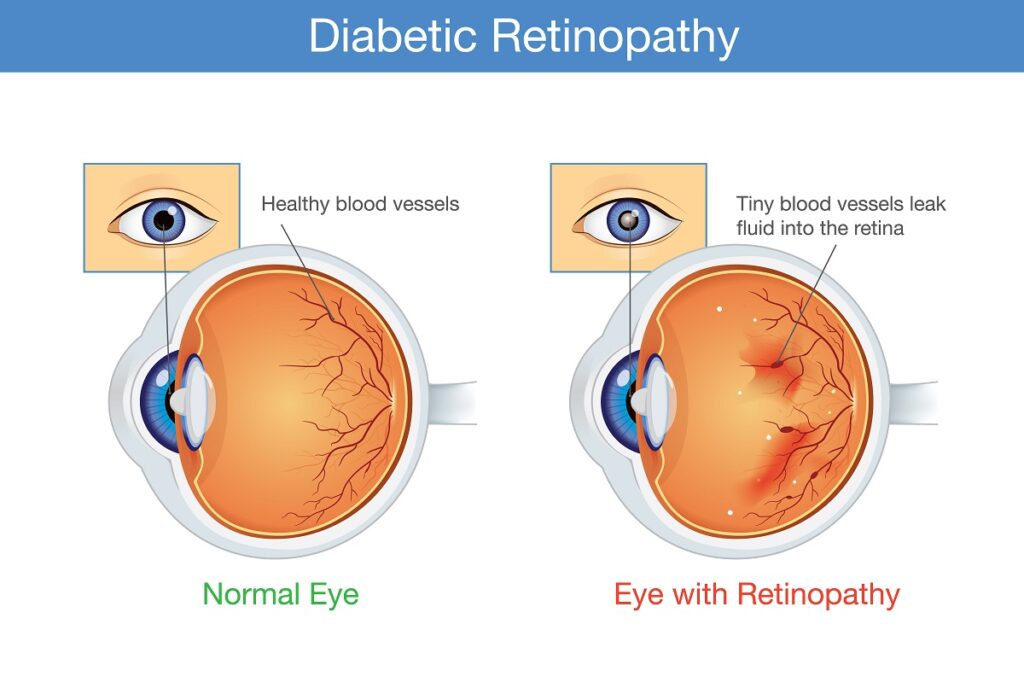

## Dataset 
In this notebook, we use APTOS 2019 Blindness Detection, which has 5 categories of fundus photographing of retina. You can reach the dataset at: https://www.kaggle.com/competitions/aptos2019-blindness-detection/overview

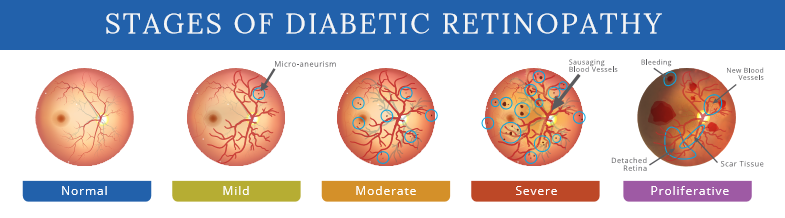

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
### define paths- make sure to change these in your code

base_dir = '/Users/namigabbasov/Desktop/Projects-Fall-2024/RetinoVision/aptos2019'
train_images_dir = os.path.join(base_dir, 'train_images')
train_csv_path = os.path.join(base_dir, 'train.csv')
test_images_dir = os.path.join(base_dir, 'train_images')
test_csv_path = os.path.join(base_dir, 'train.csv')

In [3]:
### import csv file that contains labels for training data
train_df = pd.read_csv(train_csv_path)

In [4]:
### define image size and batch size

img_size = (224, 224)  # shoudl be 224x224 images for AlexNet
batch_size = 32

In [5]:
### Prepare paths for images and labels

train_image_paths = [os.path.join(train_images_dir, img_id + '.png') for img_id in train_df['id_code']]
train_labels = train_df['diagnosis'].values

print(f'Number of image paths: {len(train_image_paths)}')
print(f'Number of labels: {len(train_labels)}')

Number of image paths: 3662
Number of labels: 3662


In [6]:
### Load and preprocess images

images = []
valid_image_paths = []
valid_labels = []

for img_path in train_image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  ### Load in color mode
    if img is None:
        print(f'Warning: Unable to load image at {img_path}')
        continue
    img = cv2.resize(img, img_size)
    images.append(img)
    valid_image_paths.append(img_path)

train_images = np.array(images)

print(f'Number of loaded images: {len(train_images)}')


### Ensure the number of images and labels match

for img_path in valid_image_paths:
    img_id = os.path.basename(img_path).replace('.png', '')
    label = train_df[train_df['id_code'] == img_id]['diagnosis'].values
    if len(label) > 0:
        valid_labels.append(label[0])

valid_labels = np.array(valid_labels)
print(f'Number of valid labels: {len(valid_labels)}')

if len(train_images) != len(valid_labels):
    raise ValueError("Number of images and labels do not match.")

train_labels = to_categorical(valid_labels, num_classes=5) 

### Split data into training and validation sets
if len(train_images) == 0:
    raise ValueError("No images loaded. Please check the image loading process.")

Number of loaded images: 3662
Number of valid labels: 3662


In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

### AlexNet 

In [8]:
### we build AlexNet model based on Sequential 
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
validation_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-26 14:07:16.389289: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-26 14:07:16.389316: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-08-26 14:07:16.389321: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-08-26 14:07:16.389334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-26 14:07:16.389343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [9]:
# Start timing
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size
)

# End timing
end_time = time.time()
training_time = end_time - start_time

print(f'Training Time: {training_time:.2f} seconds')

Epoch 1/25


2024-08-26 14:07:17.434936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.4087 - loss: 1.9522 - val_accuracy: 0.6108 - val_loss: 1.0617
Epoch 2/25
 1/91 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.7188 - loss: 0.8945

2024-08-26 14:07:35.620431: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-26 14:07:35.620452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 796204465585685258
2024-08-26 14:07:35.620457: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_88]]
2024-08-26 14:07:35.620474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4033081688102495166
2024-08-26 14:07:35.620485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2719365806903109012
2024-08-26 14:07:35.620489: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16061268239785256

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.8945 - val_accuracy: 0.7241 - val_loss: 1.0932
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.6591 - loss: 0.9666 - val_accuracy: 0.6903 - val_loss: 0.8944
Epoch 4/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6875 - loss: 1.1244 - val_accuracy: 0.8621 - val_loss: 0.7522
Epoch 5/25


2024-08-26 14:07:52.663210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4526842951309621432
2024-08-26 14:07:52.663229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17442784808464992562
2024-08-26 14:07:52.663234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4670482473158949294
2024-08-26 14:07:52.663237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16061268239785256602
2024-08-26 14:07:52.663240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17039698875413512050
2024-08-26 14:07:52.663257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5867408680809842801
2024-08-26 14:07:52.663273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.7039 - loss: 0.8392 - val_accuracy: 0.7202 - val_loss: 0.8377
Epoch 6/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.7812 - loss: 0.8050 - val_accuracy: 0.7586 - val_loss: 0.7434
Epoch 7/25


2024-08-26 14:08:09.425896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6807174929311072610
2024-08-26 14:08:09.425912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 796204465585685258
2024-08-26 14:08:09.425921: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2719365806903109012
2024-08-26 14:08:09.425928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16061268239785256602
2024-08-26 14:08:09.425933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17442784808464992562
2024-08-26 14:08:09.425936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3755983302598175410
2024-08-26 14:08:09.425939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.7163 - loss: 0.8493 - val_accuracy: 0.7230 - val_loss: 0.8364
Epoch 8/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6562 - loss: 0.7783 - val_accuracy: 0.6897 - val_loss: 0.9083
Epoch 9/25


2024-08-26 14:08:26.233944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6807174929311072610
2024-08-26 14:08:26.233963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10554832505553551457
2024-08-26 14:08:26.233968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9391002986886251005
2024-08-26 14:08:26.233982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12100418206952035131
2024-08-26 14:08:26.233986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4132828865839162759
2024-08-26 14:08:26.233989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3534210064407287621
2024-08-26 14:08:26.233991: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.7068 - loss: 0.8320 - val_accuracy: 0.7173 - val_loss: 0.8456
Epoch 10/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.5625 - loss: 0.8991 - val_accuracy: 0.8621 - val_loss: 0.5350
Epoch 11/25


2024-08-26 14:08:42.976049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9477844701444649046
2024-08-26 14:08:42.976063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4526842951309621432
2024-08-26 14:08:42.976072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3617626430723990102
2024-08-26 14:08:42.976081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10554832505553551457
2024-08-26 14:08:42.976085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9391002986886251005
2024-08-26 14:08:42.976092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4223811865930538683
2024-08-26 14:08:42.976095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.7106 - loss: 0.8280 - val_accuracy: 0.7244 - val_loss: 0.8360
Epoch 12/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7500 - loss: 0.6557 - val_accuracy: 0.6207 - val_loss: 1.0226
Epoch 13/25


2024-08-26 14:08:59.704151: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10554832505553551457
2024-08-26 14:08:59.704164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9391002986886251005
2024-08-26 14:08:59.704169: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9064288082523987931
2024-08-26 14:08:59.704172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4132828865839162759
2024-08-26 14:08:59.704185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11306158173161694779
2024-08-26 14:08:59.704188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5867408680809842801
2024-08-26 14:08:59.704191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.6971 - loss: 0.8368 - val_accuracy: 0.7017 - val_loss: 0.8749
Epoch 14/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7812 - loss: 0.5170 - val_accuracy: 0.8276 - val_loss: 0.7477
Epoch 15/25


2024-08-26 14:09:16.440773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6807174929311072610
2024-08-26 14:09:16.440786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4033081688102495166
2024-08-26 14:09:16.440790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2719365806903109012
2024-08-26 14:09:16.440793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16061268239785256602
2024-08-26 14:09:16.440796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17442784808464992562
2024-08-26 14:09:16.440799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3755983302598175410
2024-08-26 14:09:16.440801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.7028 - loss: 0.8295 - val_accuracy: 0.7301 - val_loss: 0.8248
Epoch 16/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6875 - loss: 0.7963 - val_accuracy: 0.7241 - val_loss: 0.8252
Epoch 17/25


2024-08-26 14:09:33.209218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4526842951309621432
2024-08-26 14:09:33.209295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18114285063175680524
2024-08-26 14:09:33.209303: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11035001694010364626
2024-08-26 14:09:33.209308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5867408680809842801
2024-08-26 14:09:33.209311: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10554832505553551457
2024-08-26 14:09:33.209314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12100418206952035131
2024-08-26 14:09:33.209317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.6998 - loss: 0.8355 - val_accuracy: 0.7344 - val_loss: 0.7967
Epoch 18/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7500 - loss: 0.9938 - val_accuracy: 0.6207 - val_loss: 1.1465
Epoch 19/25


2024-08-26 14:09:49.943856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15137889723279941743
2024-08-26 14:09:49.943871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9391002986886251005
2024-08-26 14:09:49.943875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4223811865930538683
2024-08-26 14:09:49.943878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4132828865839162759
2024-08-26 14:09:49.943880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5867408680809842801
2024-08-26 14:09:49.943884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18231984517605075433
2024-08-26 14:09:49.943887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.7134 - loss: 0.8110 - val_accuracy: 0.7287 - val_loss: 0.8071
Epoch 20/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.7188 - loss: 0.9164 - val_accuracy: 0.6897 - val_loss: 0.8607
Epoch 21/25


2024-08-26 14:10:06.730515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10554832505553551457
2024-08-26 14:10:06.730530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4223811865930538683
2024-08-26 14:10:06.730538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9391002986886251005
2024-08-26 14:10:06.730541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 522238493464870864
2024-08-26 14:10:06.730560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4132828865839162759
2024-08-26 14:10:06.730574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11306158173161694779
2024-08-26 14:10:06.730578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.7221 - loss: 0.8073 - val_accuracy: 0.7273 - val_loss: 0.8240
Epoch 22/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5625 - loss: 1.0202 - val_accuracy: 0.7931 - val_loss: 0.6300
Epoch 23/25


2024-08-26 14:10:23.574306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6807174929311072610
2024-08-26 14:10:23.574321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2719365806903109012
2024-08-26 14:10:23.574325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16061268239785256602
2024-08-26 14:10:23.574336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17442784808464992562
2024-08-26 14:10:23.574340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3755983302598175410
2024-08-26 14:10:23.574343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 976540285827877778
2024-08-26 14:10:23.574346: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.7136 - loss: 0.8365 - val_accuracy: 0.7315 - val_loss: 0.8431
Epoch 24/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.7188 - loss: 0.6423 - val_accuracy: 0.6552 - val_loss: 0.9318
Epoch 25/25


2024-08-26 14:10:40.334733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15137889723279941743
2024-08-26 14:10:40.334748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9391002986886251005
2024-08-26 14:10:40.334752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10554832505553551457
2024-08-26 14:10:40.334754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4223811865930538683
2024-08-26 14:10:40.334758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4132828865839162759
2024-08-26 14:10:40.334761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11306158173161694779
2024-08-26 14:10:40.334763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.7193 - loss: 0.8052 - val_accuracy: 0.7259 - val_loss: 0.8361
Training Time: 220.37 seconds


In [12]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7059 - loss: 0.8447
Validation Loss: 0.8571341037750244
Validation Accuracy: 0.6998635530471802


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


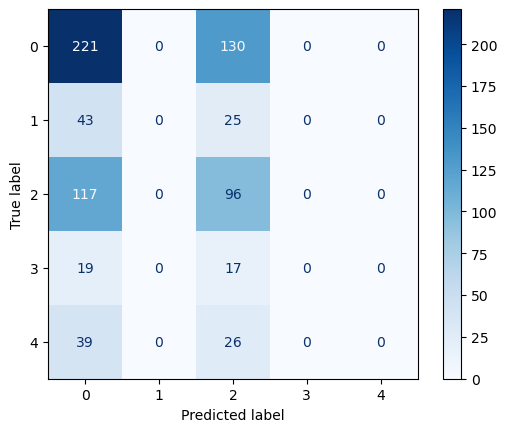

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict the classes on the validation set
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Convert the one-hot encoded validation labels back to their original form
y_true = np.argmax(y_val, axis=1)

# Step 3: Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Define paths
base_dir = '/Users/namigabbasov/Desktop/Projects-Fall-2024/RetinoVision/aptos2019'
train_images_dir = os.path.join(base_dir, 'train_images')
train_csv_path = os.path.join(base_dir, 'train.csv')

# Load the CSV file that contains labels
labels_df = pd.read_csv(train_csv_path)

# Prepare paths for images and labels
image_paths = [os.path.join(train_images_dir, img_id + '.png') for img_id in labels_df['id_code']]  # Adjust extension if needed
labels = labels_df['diagnosis'].values

print(f'Number of image paths: {len(image_paths)}')
print(f'Number of labels: {len(labels)}')

# Define image size and initialize lists for valid images and labels
img_size = (224, 224)  # Adjust size as required
images = []
valid_image_paths = []
valid_labels = []

# Load and preprocess images
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load in color mode
    if img is None:
        print(f'Warning: Unable to load image at {img_path}')
        continue
    img = cv2.resize(img, img_size)
    images.append(img)
    valid_image_paths.append(img_path)

loaded_images = np.array(images)
print(f'Number of loaded images: {len(loaded_images)}')

# Ensure the number of images and labels match
for img_path in valid_image_paths:
    img_id = os.path.basename(img_path).replace('.png', '')  # Adjust for extension
    label = labels_df[labels_df['id_code'] == img_id]['diagnosis'].values
    if len(label) > 0:
        valid_labels.append(label[0])

valid_labels = np.array(valid_labels)
print(f'Number of valid labels: {len(valid_labels)}')

if len(loaded_images) != len(valid_labels):
    raise ValueError("Number of images and labels do not match.")

# One-hot encode the labels
encoded_labels = to_categorical(valid_labels, num_classes=5)  # Adjust num_classes based on your dataset

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(loaded_images, encoded_labels, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)

Number of image paths: 3662
Number of labels: 3662
Number of loaded images: 3662
Number of valid labels: 3662


In [15]:
# Build a basic CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))  # Adjust num_classes based on your dataset

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # Adjust epochs as needed
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32
)

Epoch 1/25


/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.5103 - loss: 1.5188 - val_accuracy: 0.7131 - val_loss: 0.8271
Epoch 2/25
 1/91 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7500 - loss: 0.9103

2024-08-26 16:35:55.318136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
/Users/namigabbasov/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-26 16:35:55.318155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:35:55.318177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10904576204644778398
2024-08-26 16:35:55.318189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 690961307435985254
2024-08-26 16:35:55.318194: I tensorflow/core/framework/local_re

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.9103 - val_accuracy: 0.7241 - val_loss: 0.8101
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.6757 - loss: 0.9030 - val_accuracy: 0.7315 - val_loss: 0.7839
Epoch 4/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6562 - loss: 1.0219 - val_accuracy: 0.5862 - val_loss: 1.1733
Epoch 5/25


2024-08-26 16:36:09.278210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:36:09.278226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13215278546038878277
2024-08-26 16:36:09.278230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9893982389075755213
2024-08-26 16:36:09.278235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4597518031801536925
2024-08-26 16:36:09.278238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14249164190119892495
2024-08-26 16:36:09.278242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11947899981763041203
2024-08-26 16:36:09.278260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.6944 - loss: 0.8731 - val_accuracy: 0.7259 - val_loss: 0.7961
Epoch 6/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.8125 - loss: 0.6720 - val_accuracy: 0.8276 - val_loss: 0.7053
Epoch 7/25


2024-08-26 16:36:22.957920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:36:22.957931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9893982389075755213
2024-08-26 16:36:22.957941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:36:22.957948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10904576204644778398
2024-08-26 16:36:22.957955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 690961307435985254
2024-08-26 16:36:22.957960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6931786824662216036
2024-08-26 16:36:22.957964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.7084 - loss: 0.8234 - val_accuracy: 0.7344 - val_loss: 0.7903
Epoch 8/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6875 - loss: 0.7551 - val_accuracy: 0.7241 - val_loss: 0.8675
Epoch 9/25


2024-08-26 16:36:36.707652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:36:36.707668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5369835310678250082
2024-08-26 16:36:36.707672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15009766213595569206
2024-08-26 16:36:36.707676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6931786824662216036
2024-08-26 16:36:36.707679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13050053613022721844
2024-08-26 16:36:36.707685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13215278546038878277
2024-08-26 16:36:36.707687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.7184 - loss: 0.8084 - val_accuracy: 0.7259 - val_loss: 0.8192
Epoch 10/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7500 - loss: 0.8042 - val_accuracy: 0.8276 - val_loss: 0.4531
Epoch 11/25


2024-08-26 16:36:50.385048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:36:50.385062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:36:50.385067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5369835310678250082
2024-08-26 16:36:50.385073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15009766213595569206
2024-08-26 16:36:50.385078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13215278546038878277
2024-08-26 16:36:50.385096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4597518031801536925
2024-08-26 16:36:50.385101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.7179 - loss: 0.7918 - val_accuracy: 0.7287 - val_loss: 0.8036
Epoch 12/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.7500 - loss: 0.9383 - val_accuracy: 0.6897 - val_loss: 0.9597
Epoch 13/25


2024-08-26 16:37:03.980564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9893982389075755213
2024-08-26 16:37:03.980583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2247767454886684071
2024-08-26 16:37:03.980590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11491299422981482353
2024-08-26 16:37:03.980593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:37:03.980610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:37:03.980614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6514747107862145809
2024-08-26 16:37:03.980627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.7144 - loss: 0.8384 - val_accuracy: 0.7386 - val_loss: 0.8376
Epoch 14/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6562 - loss: 0.9616 - val_accuracy: 0.6897 - val_loss: 0.8707
Epoch 15/25


2024-08-26 16:37:17.713392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:37:17.713446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9893982389075755213
2024-08-26 16:37:17.713461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2247767454886684071
2024-08-26 16:37:17.713465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11491299422981482353
2024-08-26 16:37:17.713474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6514747107862145809
2024-08-26 16:37:17.713481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5543457964936121263
2024-08-26 16:37:17.713484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.7143 - loss: 0.7827 - val_accuracy: 0.7287 - val_loss: 0.7818
Epoch 16/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7500 - loss: 0.8730 - val_accuracy: 0.7586 - val_loss: 0.8585
Epoch 17/25


2024-08-26 16:37:31.508239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:37:31.508254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9893982389075755213
2024-08-26 16:37:31.508257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2247767454886684071
2024-08-26 16:37:31.508260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11491299422981482353
2024-08-26 16:37:31.508263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6514747107862145809
2024-08-26 16:37:31.508276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5543457964936121263
2024-08-26 16:37:31.508279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.7180 - loss: 0.7942 - val_accuracy: 0.7244 - val_loss: 0.8401
Epoch 18/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7188 - loss: 0.9140 - val_accuracy: 0.7586 - val_loss: 0.6372
Epoch 19/25


2024-08-26 16:37:45.171163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9893982389075755213
2024-08-26 16:37:45.171182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2247767454886684071
2024-08-26 16:37:45.171191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11491299422981482353
2024-08-26 16:37:45.171196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6514747107862145809
2024-08-26 16:37:45.171199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5543457964936121263
2024-08-26 16:37:45.171203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6414273575702769019
2024-08-26 16:37:45.171208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.7166 - loss: 0.7981 - val_accuracy: 0.7273 - val_loss: 0.7857
Epoch 20/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.7188 - loss: 0.9650 - val_accuracy: 0.8621 - val_loss: 0.3573
Epoch 21/25


2024-08-26 16:37:58.908980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:37:58.908997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10904576204644778398
2024-08-26 16:37:58.909010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5369835310678250082
2024-08-26 16:37:58.909023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5031843649647153794
2024-08-26 16:37:58.909025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:37:58.909032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14997442856909009592
2024-08-26 16:37:58.909035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.7156 - loss: 0.8050 - val_accuracy: 0.7330 - val_loss: 0.7705
Epoch 22/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6250 - loss: 0.7912 - val_accuracy: 0.7586 - val_loss: 0.7238
Epoch 23/25


2024-08-26 16:38:12.592210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13215278546038878277
2024-08-26 16:38:12.592223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4597518031801536925
2024-08-26 16:38:12.592230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12339892283860472529
2024-08-26 16:38:12.592235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1978792555748446631
2024-08-26 16:38:12.592238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16881947697598836999
2024-08-26 16:38:12.592240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:38:12.592251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.7417 - loss: 0.7508 - val_accuracy: 0.7315 - val_loss: 0.7711
Epoch 24/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.6875 - loss: 0.8139 - val_accuracy: 0.7241 - val_loss: 0.9099
Epoch 25/25


2024-08-26 16:38:26.285181: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5563700765814603918
2024-08-26 16:38:26.285202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9854982079518941400
2024-08-26 16:38:26.285205: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5031843649647153794
2024-08-26 16:38:26.285208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9893982389075755213
2024-08-26 16:38:26.285218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11491299422981482353
2024-08-26 16:38:26.285222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6514747107862145809
2024-08-26 16:38:26.285226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv it

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.7236 - loss: 0.7863 - val_accuracy: 0.7358 - val_loss: 0.8167


In [17]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7078 - loss: 0.8749
Validation Loss: 0.8274938464164734
Validation Accuracy: 0.7339699864387512


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


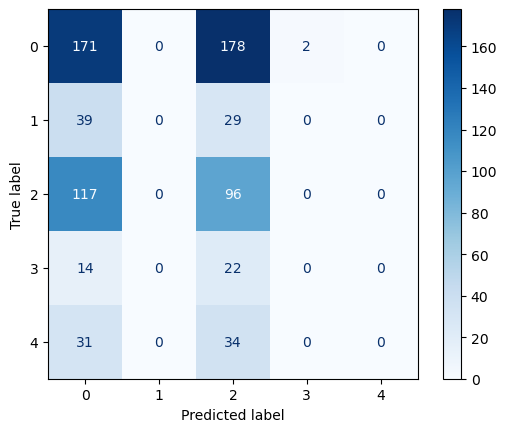

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict the classes on the validation set
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()